![STSCI banner](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# Introduction to TSO data products & the JWST TSO pipeline

Author: Sarah Kendrew, Instrument & Calibration Scientist, ESA/STScI MIRI Branch <br>
Last Updated: 17 Nov 2021<br>
Pipeline version: 1.3.3<br>

### Table of contents

1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#mirisim)<br>





# 1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>

## 1.1<font color='white'>-</font>Purpose of this notebook <a class="anchor" id="purpose"></a>

In this notebook we provide a realistic example for running the JWST pipeline on a JWST Time Series Observation (TSO). For the purposes of this tutorial we will work with a simulated observation with the MIRI Low Resolution Spectrometer (LRS). In particular, we focus on aspects of the pipeline that differ from "standard" algorihtms and procedures. There will not be enough time to look at every step in detail, but we will demonstrate how to make changes to the pipeline setting (and why you might want to do that) for the best scientific utility. 

Note that the notebook uses JWST Calibration Pipeline version 1.3.3, which is the current version at the time of this JWebbinar. The pipeline will however be further developed and updated post-launch. 

We will start with a simple simulated MIRI LRS observation, created using MIRISim version 2.4.1, which is compatible with pipeline version 1.3.3 (https://wiki.miricle.org/Public/MIRISim_Public). The data are described in more detail below. 


## 1.2<font color='white'>-</font>Input Simulations <a class="anchor" id="inputs"></a>

We used the MIRISim software package (v2.4.1) to generate realistic simulations of a MIRI LRS slitless observation of a simple stellar-type point source. The stellar SED was modelled as a simple black body spectrum with the following parameters:

* Temperature = 6230 K
* Normalised to K = 8.99, or flux of 20 mJy at 2 $\mu$m. 

LRS slitless observations are carried out in the SLITLESSPRISM subarray of the MIRI Imaging detector. The subarray has 416 rows x 72 columns (the left-most 4 columns are reference pixels, i.e. no illuminated), with sampling of 0.11 arcsec/pix. The single-frame read time for this subarray is 0.159 seconds, and the FASTR1 read mode has an extra reset between integrations. We perform an observation of 100 groups, 10 integrations, in a single exposure; giving an exposure time of:

t$_{exp}$ = ((100 + 1) $\times$ 0.159) $\times$ 10 = 160.59 s = 2.67 minutes

"Real" TSOs will typically have many more integrations than 10, with exposures covering many hours. But for the sake of reducing processing time, we use a shorter exposure here. 



### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

As noted above, in this notebook we will be processing simulated data created with the MIRIsim tool.  Like the pipeline, MIRISim is also an evolving piece of software and there are multiple known issues that can cause problems.  

**General MIRISim caveats**

- Detector noise properties are not modelled in a fully physically realistic way. It's not recommended to use these simulations "out of the box" for detailed noise investigations. 

- Reference pixels are not treated consistently, the refpix step of detector1 must therefore be turned off to process mirisim data without artifacts.

- The default detector read mode is FASTR1, which contains a reset between integrations. MIRISim still uses the FAST read mode, which does not include this extra reset. The exposure time recordedin the simulated FITS header is therefore missing this additional reset time. 

**MIRI TSO-specific caveats**

- There is no "TSO" flag in MIRISim; the software does not set the header keyword that the pipeline looks for to recignise whether an exposure is a TSO. We will set this manually in this notebook.

- MIRISim is not able to insert a time-variable signal into a simulated observation. The source flux is assumed to be constant. Additional tools have been developed in the MIRI consortium for this purpose, but for the aims of this tutorial we do not consider this. 

- The MIRI LRS prism has a leak in its transmission that causes some 3-4 $\mu$m flux to contaminate the spectrum around 6-7 $\mu$m. This is not included in the MIRISim models. 




<hr style="border:2px solid gray"> </hr>

## 2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>

In this section we set things up a number of necessary things in order for the pipeline to run successfully:

1. import the necessary python packages
2. specify the directory structure

First the imports.


In [144]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $HOME/crds_cache
%set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu


import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import astropy.io.fits as fits

from jwst import datamodels
from jwst.pipeline import calwebb_detector1, calwebb_spec2, calwebb_tso3
from jwst.associations.asn_from_list import asn_from_list
from gwcs.wcstools import grid_from_bounding_box

env: CRDS_PATH=$HOME/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


Next we will create an output directory for the new products we produce. 

In [2]:
outdir = 'miri_lrs_output'
if not os.path.exists(outdir):
    os.mkdir(outdir)


<hr style="border:1px solid gray"> </hr>

## 3.<font color='white'>-</font>Retrieving and Inspecting the Uncalibrated Data <a class="anchor" id="firstlook"></a>

In practice, you will retrieve your observational data from the [MAST archive portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). Here you can query on a host a different parameters - mission, instrument, program ID, date of execution, etc. 

In the archive you will find both uncalibrated and calibrated data. All data received from the observatory is automatically processed by the current pipeline version; this includes ancillary data such as target acquisition images. The steps that are run in the pipeline for a particular data mode can be found in the pipeline documentation for [Stage 1](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1), [Stage 2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html) and [Stage 3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html). 

This automated pipeline processing uses a set of default parameters that were determined by the instrument teams to be "good" for a typical observation, however, some observers may want to try out different settings or find better settings for their particular science case. We will show later how this works. 

For the purposes of this JWebbinar we provide a simulated observation. 


In [3]:
f = 'miri_lrs_tso_100G10I_mirisim241.fits'
#f = '/home/shared/preloaded-fits/miri_lrs_tso_100G10I_mirisim241.fits'

You can access this file and examine structure & contents using regular astropy FITS tools, like this. You can see the file has 5 extensions:

* An empty primary extension (with a header)
* SCI: the science data. This is a 4D dataset: NCOLS x NROWS x NGROUPS x NINTS. 
* PIXELDQ: data quality flags. This is a single 2D plane with dimensions NCOLS x NROWS.
* REFOUT: the MIRI reference output values. This is a MIRI specific output. 
* ASDF: the metadata for the datamodels. 

Note that normally the PXELDQ plane is added in the first pipeline stage; its presence here is a feature of MIRISIm. Only the reference columns are flagged, the rest of this array is zeros. 

_Note to Sarah: what is the pixel DQ flag 16777217 in that 5th column of the DQ array?_

In [4]:
hdu = fits.open(f)
hdu.info()

Filename: miri_lrs_tso_100G10I_mirisim241.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        51   (72, 416, 100, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (18, 416, 100, 10)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5829B]   


Using matplotlib, we can visualize the data. The first plot below shows groups 25, 50 and 100 of the first integration of the exposure. You can see how the signal builds up with increasing group number. This increase in signal forms the ''ramp'' that the pipeline will be fitting. 

The second plot shows this flux build up in 2 pixels: one in the source spectrum, and one in the background. 

_Note SK: make this figure look prettier_

2021-11-21 09:03:29,241 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_48718/2088895007.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ql_fig.legend([sc1, sc2], labels=px_labels, loc='lower center', fontsize='x-large', ncol=2)



(10, 100, 416, 72)


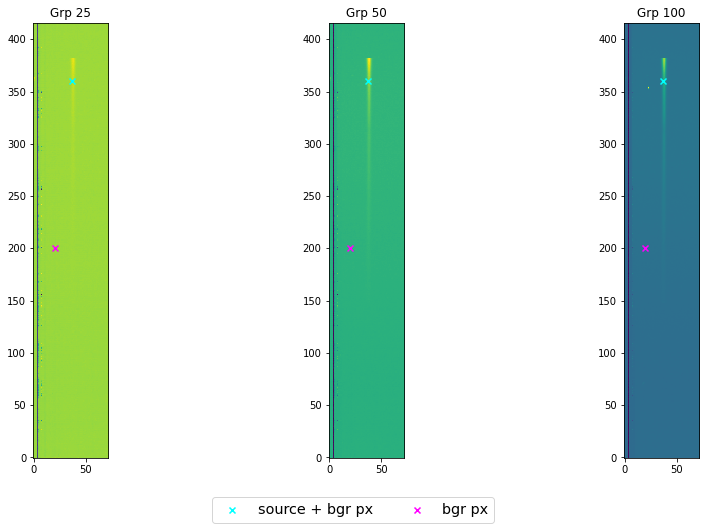

In [33]:
uncal_fits = hdu[1].data
print(np.shape(uncal_fits))

nints = np.shape(uncal_fits)[0]

# identifying pixels in source and background regions
src_px = [37, 360]
bgr_px = [20, 200]
px_labels = ["source + bgr px", "bgr px"]


ql_fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[15,8])
plt_ints = [24, 49, 99]



for i, pi in enumerate(plt_ints):
    ax[i].imshow(uncal_fits[8, pi, :, :], origin='lower', aspect='equal', interpolation='None')
    ax[i].set_title('Grp {}'.format(pi+1))
    sc1 = ax[i].scatter(src_px[0], src_px[1], marker='x', color='cyan')
    sc2 = ax[i].scatter(bgr_px[0], bgr_px[1], marker='x', color='magenta')

ql_fig.legend([sc1, sc2], labels=px_labels, loc='lower center', fontsize='x-large', ncol=2)




2021-11-21 09:03:33,864 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_48718/2975904034.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ramp_fig.show()



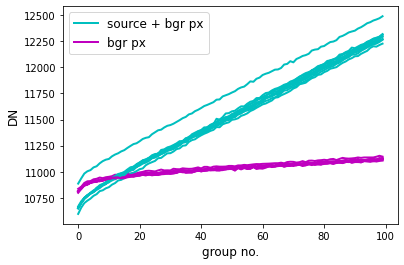

In [34]:


ramp_fig, ax = plt.subplots()
for i in range(nints):
    ax.plot(uncal_fits[i,:,src_px[1], src_px[0]], 'c-', lw=2)
    ax.plot(uncal_fits[i,:,bgr_px[1], bgr_px[0]], 'm-', lw=2)

leg = [Line2D([0], [0], lw=2, color='c', label='source + bgr px'), 
       Line2D([0], [0], lw=2, color='m', label='bgr px')]   
    
ax.set_xlabel('group no.', fontsize='large')
ax.set_ylabel('DN', fontsize='large')
ax.legend(handles=leg, loc=2, fontsize='large')

ramp_fig.show()


### 3.1 Introduction to JWST datamodels

The JWST Calibration Pipeline ("the pipeline") provides datamodels for convenient accessing and working with the data. These datamodels are effectively containers that are optimised for particular JWST data types. More information is available [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/index.html).

You don't need to know what specific model your data corresponds to. The ``datamodels.open`` function checks the relevant header keywords and matches the data against an existing model. 

In the cells below we will explore come useful aspects of the datamodels. 

In [35]:
uncal = datamodels.open(f)
print(uncal)
print(uncal.info())


<RampModel(10, 100, 416, 72) from miri_lrs_tso_100G10I_mirisim241.fits>
root (AsdfObject)
├─asdf_library (Software) ...
├─history (dict) ...
├─_fits_hash (str): fb7f90ed45c8c3bfce233dde22f04ef8a93501d6199ac41c24f9755bf787b342
├─columns (int): 72
├─data (NDArrayType): shape=(10, 100, 416, 72), dtype=float32
├─groupgap (int): 0
├─grpavg (int): 1
├─include_err (bool): False
├─include_groupdq (bool): False
├─include_pixeldq (bool): True
├─intavg (int): 1
├─maskwith (str): pixeldq
├─meta (dict) ...
├─nframes (int): 1
├─ngroups (int): 100
├─ngroups_file (int): 100
├─nints (int): 10
├─nints_file (int): 10
├─noerr (bool): True
├─pixeldq (ndarray): shape=(416, 72), dtype=uint32
├─rampdata (bool): True
└─7 not shown
Some nodes not shown.
None


This schema gives us a first look at the the model attributes, and how the metadata is packaged in the model. Most importantly, the science data is in the ``uncal.data`` attribute.  If you aren't sure where to find a particular keyword, the function ``uncal.find_fits_keyword()`` can identify it for you. 

In [37]:
print('The number of groups per integration in the exposure is {0}'.format(uncal.ngroups))
print('The number of integrations in the exposure is {0}'.format(uncal.nints))
print('Information on the filter used in this exposure can be found here: {0}'.format(uncal.find_fits_keyword('FILTER')))
print('OK! So the filter used is {0}, which is the LRS double prism')



The number of groups per integration in the exposure is 100
The number of integrations in the exposure is 10
Information on the filter used in this exposure can be found here: ['meta.instrument.filter']
OK! So the filter used is {0}, which is the LRS double prism


We can recreate the above plot using datamodel syntax

2021-11-21 09:06:39,888 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_48718/4035998592.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ql_fig2.legend([sc1, sc2], labels=px_labels, loc='lower center', fontsize='x-large', ncol=2)



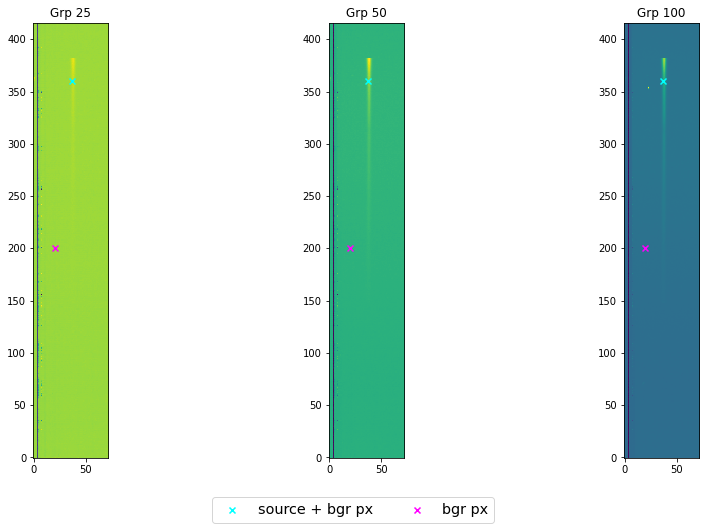

In [39]:
ql_fig2, ax2 = plt.subplots(ncols=3, nrows=1, figsize=[15,8])
plt_ints = [24, 49, 99]

for i, pi in enumerate(plt_ints):
    ax2[i].imshow(uncal.data[8, pi, :, :], origin='lower', aspect='equal', interpolation='None')
    ax2[i].set_title('Grp {}'.format(pi+1))
    sc1 = ax2[i].scatter(src_px[0], src_px[1], marker='x', color='cyan')
    sc2 = ax2[i].scatter(bgr_px[0], bgr_px[1], marker='x', color='magenta')

ql_fig2.legend([sc1, sc2], labels=px_labels, loc='lower center', fontsize='x-large', ncol=2)





The ``meta`` attribute of the model is particular rich in unseful information. We'll show some of its useful features in the next cell. Not all attributes of the model are correctly populated as the MIRISim simulation data lacks some of the JWST observatory keywords. 


We show here that the "TSOVISIT" keyword or attribute is not set. This is a MIRISim issue, and we'll show below how we set this manually in the data model to ensure that the pipeline recognizes the exposure as a TSO.

In [72]:
print('Total exposure time is {:.2f} seconds'.format(uncal.meta.exposure.exposure_time))
print('Detector readout pattern was {0} mode'.format(uncal.meta.exposure.readpatt))      
print('The original filename of this RampModel was {0}'.format(uncal.meta.filename))     
print('The most amazing space telescope bar none is {0}'.format(uncal.meta.telescope))   
print('TSOs should have this attribute set to True and instead it reads {0}'.format(uncal.meta.visit.tsovisit))

# Let's change the TSO status
if not uncal.meta.visit.tsovisit:
    uncal.meta.visit.tsovisit = True

print('Now the TSO setting reads {0}'.format(uncal.meta.visit.tsovisit))


Total exposure time is 159.04 seconds
Detector readout pattern was FAST mode
The original filename of this RampModel was miri_lrs_tso_100G10I_mirisim241.fits
The most amazing space telescope bar none is JWST
TSOs should have this attribute set to True and instead it reads None
Now the TSO setting reads True


### Summary and further reading

In this section, we:
* loaded the uncalibrated MIRISim data for a slitless LRS exposure
* showed how to load the data using datamodels
* showed some of the useful features of datamodels and how metadata is organised in the model attributes
    
    
Further reading
*




## 4.<font color='white'>-</font>Intro to Running the Pipeline: CalDetector1() <a class="anchor" id="pipeline"></a>

In this section we will demonstrate how to run the JWST calibration pipeline on TSO data. When you retrieve your data from the archive, you will have pipeline processed data available for download already; however as part of your research you may well want to rerun the pipeline, or specific steps or stages, to optimise certain settings for your targets.

We will highlight here a few pipeline steps that you may want to skip or modify for TSOs, and show how to do that. 

The pipeline consists of [**3 stages**](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html#pipelines). For TSOs, these are:

* CalDetector1: implements basic detector calibrations and converting ramps to slopes
* CalImage2 or CalSpec2: performs additional instrument- or mode-level calibrations, returning flux calibrated images for imaging data, and flux calibrated images and extracted spectra for spectroscopic data. 
* CalTso3: higher level calibrations, returning more TSO-specific output products

In the next sections we will run our MIRI LRS data through these pipeline stages, highlighting basic functionality, output products and suggested modifications. We will start with an introduction to the basic call sequence for the pipeline. 



### 4.1 Running the Pipeline: Basics

Full documentation for running the pipeline from within Python can be found on the [main pipeline documentation pages](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#running-from-within-python). In additional, materials for other JWebbinars providing more general instroductions to the pipeline can be found [here](https://www.stsci.edu/jwst/science-execution/jwebbinars).

In our import statements above we imported the modules ``calwebb_detector1``, ``calwebb_spec2`` and ``calwebb_tso3`` from ``jwst.pipeline``. The most basic call sequence looks as follows:

``det1 = calwebb_detector1.Detector1Pipeline.call(f)`` passing the FITS file to the call sequence; or<br>

``det1 = calwebb_detector1.Detector1Pipeline.call(uncal)`` using the previously loaded datamodel as input. <br>

In this case we will work with the ``uncal`` datamodel, as we made a modification to it in the above section. Let's see what happens. 




In [74]:
#print(uncal.meta.visit.tsovisit)
det1 = calwebb_detector1.Detector1Pipeline.call(uncal, output_dir=outdir, save_results=True)
print(det1)
!ls miri_lrs_output


2021-11-21 13:25:02,565 - CRDS - INFO -  Fetching  $HOME/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0002.asdf    1.5 K bytes  (1 / 1 files) (0 / 1.5 K bytes)


True


2021-11-21 13:25:02,886 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: $HOME/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0002.asdf
2021-11-21 13:25:02,910 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-11-21 13:25:02,911 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-11-21 13:25:02,912 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-11-21 13:25:02,914 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-11-21 13:25:02,915 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-11-21 13:25:02,916 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-11-21 13:25:02,918 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-11-21 13:25:02,920 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-11-21 13:25:02,921 - stpipe.Detector1Pipeline.fir

2021-11-21 13:25:03,468 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-11-21 13:25:03,469 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '$HOME/crds_cache/references/jwst/miri/jwst_miri_reset_0043.fits'.
2021-11-21 13:25:03,469 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '$HOME/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2021-11-21 13:25:03,470 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-11-21 13:25:03,471 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-11-21 13:25:03,628 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from miri_lrs_tso_100G10I_mirisim241.fits>,).
2021-11-21 13:25:03,631 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-11-21 13:25:07,350 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'miri_lrs_output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2021-11-21 13:25:07,379 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits
2021-11-21 13:25:07,726 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0
2021-11-21 13:25:07,727 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2021-11-21 13:25:07,928 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-11-21 13:25:08,113 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running wit

2021-11-21 13:25:11,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2021-11-21 13:25:11,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups
2021-11-21 13:25:12,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:
2021-11-21 13:25:12,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5341 pixels with at least one CR and at least four groups
2021-11-21 13:25:12,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2021-11-21 13:25:12,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups
2021-11-21 13:25:12,663 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.08854 sec
2021-11-21 13:25:12,665 - stpipe.Detector1Pipeline.jump - 

<ImageModel(416, 72) from miri_lrs_tso_100G10I_mirisim241_rate.fits>
miri_lrs_tso_100G10I_mirisim241_ramp.fits
miri_lrs_tso_100G10I_mirisim241_rate.fits
miri_lrs_tso_100G10I_mirisim241_rateints.fits


If we see no errors, the pipeline successfully ran on our data. The print statement for ``det1`` shows that the pipeline has produced an ImagModel with dimensions (416, 72), which are the correct dimensions for our subarray, corresponding to the output file miri_lrs_tso_100G10I_mirisim241_rate.fits. This is the slope image in DN/s, co-added over all integrations. 

We can see that the output directory contains an additional file, miri_lrs_tso_100G10I_mirisim241_rateints.fits. This is the file that contains the slope images for each integration, which is the product we want to use for TSOs. Let's take a look at the contents of this file. 

2021-11-21 13:27:37,549 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_48718/2983923011.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sl_fig.show()



['miri_lrs_output/miri_lrs_tso_100G10I_mirisim241_rateints.fits']
<CubeModel(10, 416, 72) from miri_lrs_tso_100G10I_mirisim241_rateints.fits>


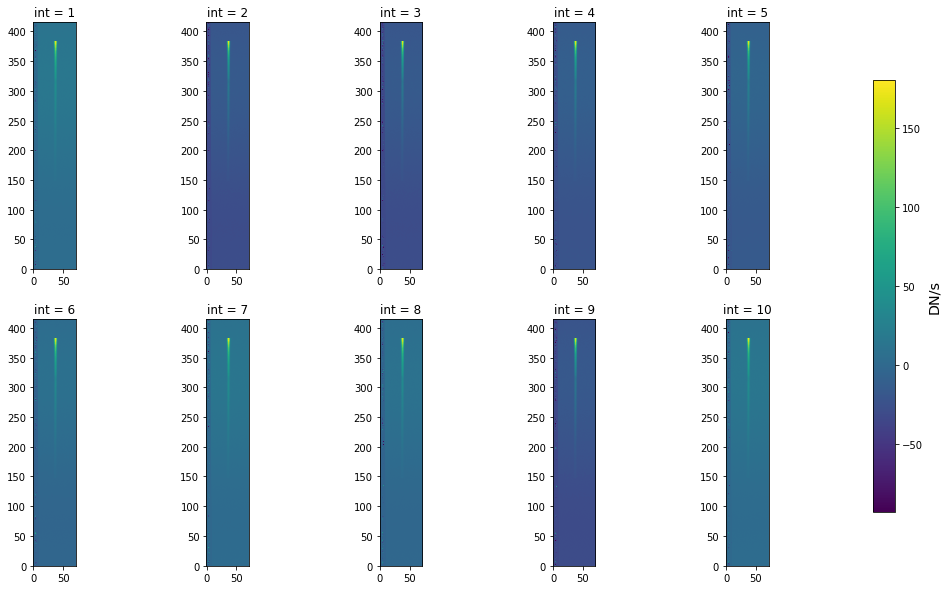

In [75]:
rifile = glob.glob(outdir+'/*rateints.fits')
print(rifile)

rate_ints = datamodels.open(rifile[0])
print(rate_ints)

sl_fig, axs = plt.subplots(ncols=5, nrows=2, figsize=[15,10])

for i,aa in enumerate(axs.flat):
    im = aa.imshow(rate_ints.data[i,:,:], origin='lower', aspect='equal', interpolation='None')
    aa.set_title('int = {0}'.format(i+1))

    
sl_fig.subplots_adjust(right=0.9)
cbar_ax = sl_fig.add_axes([0.95, 0.2, 0.02, 0.6])
cbar = sl_fig.colorbar(im, cax=cbar_ax)
cbar.set_label('DN/s', fontsize='x-large')
sl_fig.show()


OK, let's now dig a bit deeper in what the pipeline is doing to learn more about reference files and to prepare for making some changes. The steps the pipeline runs for a particular mode are defined in a [parameter file in ASDF format](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/config_asdf.html#config-asdf-files) (ASDF stands for Advanced Scientific Data Format). Asdf file can be read with a simple text editor, and a python package ``asdf`` exists to access programmatically.  

There's a handy function called ``get_crds_parameters`` that prints out all the metadata in the model, including information on the provenance of the file, data units, the calibration steps run (the ``cal_step`` entries), the version of the pipeline that was used (``calibration_software_version``), the names of the reference files used for calibration (``ref_file`` entries) and more.




In [87]:
rate_ints.get_crds_parameters()

{'asdf_library.author': 'The ASDF Developers',
 'asdf_library.homepage': 'http://github.com/asdf-format/asdf',
 'asdf_library.name': 'asdf',
 'asdf_library.version': '2.8.1',
 'history.extensions.0.extension_class': 'asdf.extension.BuiltinExtension',
 'history.extensions.0.software.name': 'asdf',
 'history.extensions.0.software.version': '2.8.1',
 '_fits_hash': 'e01e6f5e83867fa602560f61efc8edd9491e390673d19be63fe98e47d2e20b07',
 'meta.bunit_data': 'DN/s',
 'meta.bunit_err': 'DN/s',
 'meta.cal_step.dark_sub': 'COMPLETE',
 'meta.cal_step.dq_init': 'COMPLETE',
 'meta.cal_step.gain_scale': 'SKIPPED',
 'meta.cal_step.group_scale': 'SKIPPED',
 'meta.cal_step.jump': 'COMPLETE',
 'meta.cal_step.linearity': 'COMPLETE',
 'meta.cal_step.ramp_fit': 'COMPLETE',
 'meta.cal_step.refpix': 'SKIPPED',
 'meta.cal_step.reset': 'COMPLETE',
 'meta.cal_step.saturation': 'COMPLETE',
 'meta.calibration_software_revision': 'RELEASE',
 'meta.calibration_software_version': '1.3.3',
 'meta.coordinates.reference_fr

### 4.2 Retrieving and examining reference files

Reference files and parameter files for the calibration pipeline live in the **JWST Calibration Reference Data System** - [CRDS](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#crds). You can see this acronym referenced throughout the pipeline documentation, and in the metadata for the exposures. 

Each version of the pipeline has an associated CRDS **context**; you can see the context used in our Detector1Pipeline run in ``rate_ints.meta.ref_file.crds.context_used`` as ``jwst_0776.pmap``. Sometimes it may be necessary to change this setting, in order to run the pipeline with older reference files. 

The CRDS system can be accessed programmatically, or simply via the following URL: https://jwst-crds.stsci.edu, from where you can download reference files with a simple click. In the figures below you can see the web interface for CRDS, and how we can locate the parameter ASDF files for individual pipeline stages and steps. See if you can retrieve the ASDF file used for our Detector1Pipeline run?

In the cell below we then demonstrate how to access a CRDS file programmatically and override it in a pipeline run.

![Fig 1 CRDS interface](images/crds_interface.png)

![Fig 2 Det1 parameter file](images/crds_miri_det1.png)

jwst_miri_readnoise_0070.fits


2021-11-21 19:39:25,647 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_48718/1342270572.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  rd_fig.show()



<ReadnoiseModel(416, 72) from jwst_miri_readnoise_0070.fits>


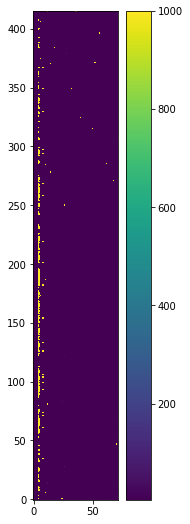

In [115]:
from astropy.utils.data import download_file


read_noise_file = (rate_ints.meta.ref_file.readnoise.name).split('/')[-1]
print(read_noise_file)
file_path = download_file('https://jwst-crds.stsci.edu/unchecked_get/references/jwst/'+read_noise_file)
os.rename(file_path, read_noise_file)

#reference files can also be read in with JWST datamodels!
read_noise = datamodels.open(read_noise_file)
print(read_noise)

rd_fig, rd_ax = plt.subplots(figsize=[3,9])
rd_im = rd_ax.imshow(read_noise.data, origin='lower', aspect='equal', interpolation='None')
rd_fig.colorbar(rd_im, ax=rd_ax)
rd_fig.show()

OK, we've now seen how to run the pipeline with its default settings, and where to find the information about those settings. Via the datamodel metadata we can see the filenames of any reference files that were used, the CRDS context. We can access these files from a web interface or programmatically. 

Next, let's see how we can make changes to these settings. 

<hr style="border:2px solid gray"> </hr>

### 4.3 Making changes to the pipeline steps

It will be a pretty common occurrence that you want to investigate the impact of a particular calibration step on your analysis, change a parameter, or try using a different reference file. In this section we'll look at how to do that. 

__First__, we will take the above read noise reference file, change its filename and rerun the ``Detector1Pipeline()`` step with the new (but unchanged) file. This demonstrates how a reference file can be _overridden_. The read noise reference file is references in both the jump step and in the ramp fitting. 

(**Note:** The basic detector calibration reference files were created following very detailed ground testing and often lengthy detector investigations. We show here how to override the read noise file to demonstrate the _method_; we recommend you replace Detector1 reference files with _extreme caution_). 

__Second__, we are finding that the jump step is flagging too many pixels as cosmic rays. We want to increase the jump threhold where the step flags the pixel as a cosmic. Here we demonstrate how to change a step _parameter_. 

__Third__, we would like the ``Detector1Pipeline()`` to run the ``lastframe`` step. The MIRI detectors have an odd pull-down effect on the last frame (group) in an integration. This introduces a deviation from the (quasi-) linear response of the detector, and as the effect has an odd-even row dependence, it can impact line measurements, especially if we are looking at line ratios. However, this effect is also stable over time for a given source, so for TSOs we prefer to use the last frame for maximal SNR. But if we consider a situation where the absolute flux calibration _is_ important - for example to match the data with that from another instrument, then we may want to rerun the pipeline to include the step (and _exclude_ the last frame in the ramp fit). 





In [124]:
# Change 1: copy the read noise reference file to a different file (make no other changes)
new_readnoise = 'miri_new_readnoise_file.fits'
shutil.copyfile(read_noise_file, new_readnoise)

# Change 2: set a new rejection threshold
rej_thresh = 10.

# Bring it all together
d1mod = calwebb_detector1.Detector1Pipeline.call(uncal, output_dir=outdir, save_results=True,
                                           steps={'jump': {'rejection_threshold':rej_thresh, 'override_readnoise': new_readnoise},
                                                  'ramp_fit': {'override_readnoise': new_readnoise},
                                                  'lastframe': {'skip': False}})



2021-11-21 20:32:20,283 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: $HOME/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0002.asdf
2021-11-21 20:32:20,301 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-11-21 20:32:20,302 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-11-21 20:32:20,303 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-11-21 20:32:20,305 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-11-21 20:32:20,306 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-11-21 20:32:20,307 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-11-21 20:32:20,308 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-11-21 20:32:20,309 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-11-21 20:32:20,310 - stpipe.Detector1Pipeline.fir

2021-11-21 20:32:20,804 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-11-21 20:32:20,805 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '$HOME/crds_cache/references/jwst/miri/jwst_miri_reset_0043.fits'.
2021-11-21 20:32:20,805 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '$HOME/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2021-11-21 20:32:20,806 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-11-21 20:32:20,807 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-11-21 20:32:21,242 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from miri_lrs_tso_100G10I_mirisim241.fits>,).
2021-11-21 20:32:21,244 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-11-21 20:32:27,198 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'miri_lrs_output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2021-11-21 20:32:27,228 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits
2021-11-21 20:32:27,523 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0
2021-11-21 20:32:27,524 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2021-11-21 20:32:27,716 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-11-21 20:32:28,178 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running wit

2021-11-21 20:32:30,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2021-11-21 20:32:30,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups
2021-11-21 20:32:30,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:
2021-11-21 20:32:31,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 1697 pixels with at least one CR and at least four groups
2021-11-21 20:32:31,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups
2021-11-21 20:32:31,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups
2021-11-21 20:32:31,189 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.27432 sec
2021-11-21 20:32:31,191 - stpipe.Detector1Pipeline.jump - 

In [133]:
# Now let's check if our changes were applied
print('Read noise reference file used was {0}'.format(d1mod.meta.ref_file.readnoise.name))
print('The last frame step status: {0}'.format(d1mod.meta.cal_step.lastframe))

Read noise reference file used was miri_new_readnoise_file.fits
The last frame step status: COMPLETE


ValuesView(<stdatamodels.ndmodel.MetaNode object at 0x7fe95341e760>)

## <font color='white'>-</font>5. Progressing Further: Spec2Pipeline()<a class="anchor" id="spec2pipe"></a>

We have demonstrated some basics of the pipeline using Stage 1 of the Pipeline, which has converted ramps to slopes for each integration in the exposure. In this section we will run our data through Stage 2 of the pipeline, showing the following methods:

* Running and configuring individual steps
* Inspecting the WCS information
* Spectral extraction and making modifications


### 5.1 Introduction to the Stage 2 Pipeline

In Stage 2 of the pipeline, the following calibrations are applied to our MIRI LRS data:

1. Assigning a world coordinate system (including wavelengths)
2. Assigning a source type
3. Flat fielding
4. Photometric calibration
5. Spectral extraction

The Stage 2 pipeline has many more steps, but many do not apply to TSOs. For the full list of steps and which instruments and modes use what steps, see the [pipeline doumentation pages](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2). 

Note that imaging TSOs use the Image2Pipeline(), [described here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html).


### 5.2 Running the pipeline step by step

In the previous section we called the Stage 1 pipeline as a single step, via ``calwebb_detector1.Detector1Pipeline.call()``. This method works also for Stage 2, using the ``rateints.fits`` file as input. The call sequence is as follows:

``spec2_out = calwebb_spec2.Spec2Pipeline.call(rate_ints, save_results=True, output_dir=out_dir)``

However in this section we will demonstrate how to run individual steps one by one, which can make it easier to configure and modify steps.

Let's first import the individual steps of the Stage 2 pipeline. 


In [137]:
from jwst.assign_wcs import AssignWcsStep
from jwst.srctype import SourceTypeStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from jwst.extract_1d import Extract1dStep



OK, that's all imported. Let's start with the ``assign_wcs`` step. We can accept all default settings for this step. This step makes no modifications to the science data. It only attaches WCS information to the data, including wavelength, such that every pixel in the detector array has an associated (RA, Dec, wavelength). It also defines a bounding box region over which these values are defined (with NaNs everywhere else). 

In [141]:
awcs = AssignWcsStep.call(rate_ints, save_results=True, output_dir=outdir)
print(awcs)

2021-11-22 15:27:35,656 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-11-22 15:27:36,112 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<CubeModel(10, 416, 72) from miri_lrs_tso_100G10I_mirisim241_rateints.fits>,).
2021-11-22 15:27:36,114 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'miri_lrs_output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-11-22 15:27:36,141 - CRDS - INFO -  Fetching  $HOME/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf    9.9 K bytes  (1 / 1 files) (0 / 9.9 K bytes)
2021-11-22 15:27:36,794 - CRDS - 

<CubeModel(10, 416, 72) from miri_lrs_tso_100G10I_mirisim241_assignwcsstep.fits>


From the ``print`` statement above we can see that the output data is a CubeModel, still with the dimensions of the ``rateints.fits`` file. The step has produced a new output file, ``miri_lrs_tso_100G10I_mirisim241_assignwcsstep.fits``, which we can also access via the step output, ``awcs``. 

Let's look at the bounding box that was defined on the aperture, and how we can retrieve a wavelength map. For this we need to import a function from the ``gwcs`` package that comes with the JWST pipeline. We use this to plot a 2D wavelength map of the subarray. As MIRISim simulated data do not contain realistic coordinates, we do not show the RA, Dec - but the method shown works for this too with on-sky data. 

In [155]:
from gwcs.wcstools import grid_from_bounding_box

Corner pixel coordinates of the bounding box: ((3.5, 71.5), (6.5, 397.5))
Bounding box height: 391.0 px; width: 68.0 px


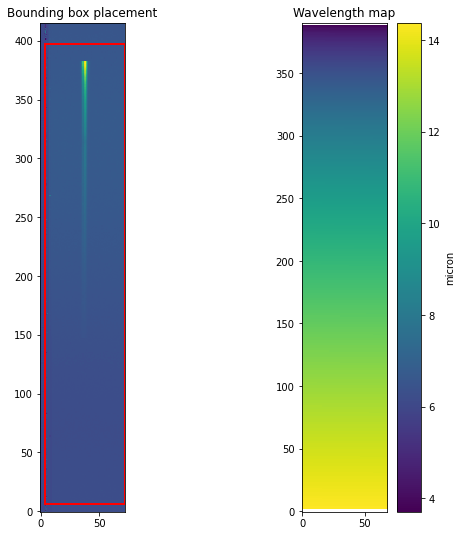

In [156]:
print('Corner pixel coordinates of the bounding box: {0}'.format(awcs.meta.wcs.bounding_box))

bbox_w = awcs.meta.wcs.bounding_box[0][1] - awcs.meta.wcs.bounding_box[0][0]
bbox_ht = awcs.meta.wcs.bounding_box[1][1] - awcs.meta.wcs.bounding_box[1][0]
print('Bounding box height: {0} px; width: {1} px'.format(bbox_ht, bbox_w))

# Now let's calculate the grid
x,y = grid_from_bounding_box(awcs.meta.wcs.bounding_box)
ra, dec, lam = awcs.meta.wcs(x, y)

bbfig, bbax = plt.subplots(ncols=2, nrows=1, figsize=[8,9])
bbox = Rectangle((awcs.meta.wcs.bounding_box[0][0],awcs.meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

bbax[0].imshow(awcs.data[1,:,:], origin='lower', interpolation='None', aspect='equal')
bbax[0].add_patch(bbox)
bbax[0].set_title('Bounding box placement', fontsize='large')

wim = bbax[1].imshow(lam, origin='lower', aspect='equal', interpolation='None')
bbax[1].set_title('Wavelength map', fontsize='large')
bbfig.colorbar(wim, ax=bbax[1], label='micron')
